# Loi d'Amdahl – Analyse empirique

Notebook basé sur `benchmarks/results.jsonl`.


In [13]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.style.use('seaborn-v0_8-colorblind')

JSONL_PATH = Path('benchmarks/results.jsonl')
if not JSONL_PATH.exists():
    raise FileNotFoundError(f'Fichier JSONL introuvable: {JSONL_PATH}')

records = []
with JSONL_PATH.open('r', encoding='utf-8') as fh:
    for line in fh:
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
        except json.JSONDecodeError:
            continue
        records.append(rec)

if not records:
    raise ValueError('Le JSONL ne contient aucun enregistrement exploitable.')

df = pd.DataFrame(records)
for col in ['workers', 'splits', 'duration_seconds', 'total_words', 'unique_words']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['workers', 'splits', 'duration_seconds'])
if df.empty:
    raise ValueError('Toutes les lignes ont été filtrées (valeurs manquantes).')

df['workers'] = df['workers'].astype(int)
df['splits'] = df['splits'].astype(int)


In [14]:
def flatten_lang(entry):
    if isinstance(entry, list):
        out = []
        for item in entry:
            if isinstance(item, dict) and 'lang' in item and 'count' in item:
                try:
                    out.append((item['lang'], int(item['count'])))
                except (TypeError, ValueError):
                    continue
        return out
    return []

df['language_pairs'] = df.get('languages', []).apply(flatten_lang)
df.head()


,timestamp,workers,splits,duration_seconds,total_words,unique_words,top_words,per_worker,languages,output_dir,language_pairs
0,2025-11-19T01:03:59.384922+00:00,1,10,1104.948403,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
1,2025-11-19T01:12:44.852307+00:00,2,10,440.683032,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
2,2025-11-19T01:18:52.035809+00:00,3,10,299.764858,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
3,2025-11-19T01:23:50.988805+00:00,4,10,219.566310,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."
4,2025-11-19T01:29:34.146563+00:00,5,10,241.293791,405875030,7276313,"[{'word': 'the', 'count': 4613558}, {'word': '...","[{'file': 'tp-1a226-01_wordcount.json', 'total...","[{'lang': 'en', 'count': 6691}, {'lang': 'ru',...",/cal/exterieurs/blepourt-25/hadoop_homemade/ou...,"[(en, 6691), (ru, 1090), (de, 969), (fr, 663),..."


In [15]:

import math
from typing import Dict, Iterable, List, Tuple

if not {'workers', 'splits', 'duration_seconds'}.issubset(df.columns):
    raise KeyError('Colonnes workers/splits/duration_seconds manquantes.')

grouped = (
    df.groupby(['splits', 'workers'], as_index=False)
      .agg(
          elapsed_seconds=('duration_seconds', 'mean'),
          elapsed_std=('duration_seconds', 'std'),
          run_count=('duration_seconds', 'count'),
      )
)

grouped['elapsed_std'] = grouped['elapsed_std'].fillna(0.0)


def amdahl_speedup(workers: Iterable[int], seq_fraction: float, parallel_eff: float = 1.0) -> List[float]:
    result: List[float] = []
    for w in workers:
        denom = seq_fraction + (1.0 - seq_fraction) / (parallel_eff * w)
        result.append(1.0 / denom)
    return result


def fit_parallel_efficiency(rows: List[dict], seq_fraction: float, bounds: Tuple[float, float] = (0.1, 2.0)) -> float:
    data = [
        (int(r['workers']), float(r['speedup_observe']))
        for r in rows
        if math.isfinite(r['speedup_observe']) and r['speedup_observe'] > 0
    ]
    if not data:
        return 1.0

    def error(p: float) -> float:
        preds = amdahl_speedup([w for w, _ in data], seq_fraction, p)
        return sum((pred - speed) ** 2 for pred, (_, speed) in zip(preds, data))

    p_min, p_max = bounds
    best_p = p_min
    best_err = error(best_p)
    steps = 200
    for i in range(steps + 1):
        candidate = p_min + (p_max - p_min) * i / steps
        err = error(candidate)
        if err < best_err:
            best_p = candidate
            best_err = err

    step = (p_max - p_min) / steps
    while step > 1e-3:
        improved = False
        for candidate in (best_p - step, best_p + step):
            if not (p_min <= candidate <= p_max):
                continue
            err = error(candidate)
            if err < best_err:
                best_p = candidate
                best_err = err
                improved = True
        if not improved:
            step /= 2
    return best_p


summary_rows: List[dict] = []
split_models: Dict[int, Dict[str, float]] = {}
for splits_val, subset in grouped.groupby('splits', sort=True):
    subset = subset.sort_values('workers')
    base_row = subset[subset['workers'] == 1]
    if base_row.empty:
        diag_row = subset[subset['workers'] == splits_val]
        if diag_row.empty:
            continue
        base_duration = float(diag_row['elapsed_seconds'].iloc[0]) * int(splits_val)
    else:
        base_duration = float(base_row['elapsed_seconds'].iloc[0])
    rows_for_split: List[dict] = []
    for row in subset.itertuples():
        duration = float(row.elapsed_seconds)
        speedup = base_duration / duration if duration > 0 else math.nan
        rows_for_split.append(
            {
                'splits': int(splits_val),
                'workers': int(row.workers),
                'elapsed_seconds': duration,
                'elapsed_std': float(row.elapsed_std),
                'run_count': int(row.run_count),
                'speedup_observe': speedup,
            }
        )

    valid_rows = [
        r for r in rows_for_split if math.isfinite(r['speedup_observe']) and r['speedup_observe'] > 0
    ]
    if not valid_rows:
        continue
    max_speedup = max(r['speedup_observe'] for r in valid_rows)
    seq_fraction = 1.0 / max_speedup
    parallel_eff = fit_parallel_efficiency(valid_rows, seq_fraction)

    for row in rows_for_split:
        row['speedup_pred_amdahl'] = amdahl_speedup([row['workers']], seq_fraction, parallel_eff)[0]
        row['p_parallel_estimate'] = parallel_eff

    split_models[int(splits_val)] = {
        'seq_fraction': seq_fraction,
        'parallel_eff': parallel_eff,
        'base_duration': base_duration,
        'speedup_limit': max_speedup,
    }
    summary_rows.extend(rows_for_split)
    print(
        f"Splits={splits_val}: limite≈{max_speedup:.2f}, s≈{seq_fraction:.4f}, p≈{parallel_eff:.3f}"
    )

if not summary_rows:
    raise ValueError('Impossible de calculer des speedups : aucune base workers=1 trouvée.')

summary = (
    pd.DataFrame(summary_rows)
      .sort_values(['splits', 'workers'])
      .reset_index(drop=True)
)

amdahl_dense = pd.DataFrame()
if split_models:
    # Choisir le split avec le plus de travailleurs distincts (plutôt que le dernier)
    if not summary.empty:
        counts = (
            summary.groupby('splits')['workers']
            .nunique()
            .reset_index(name='num_workers')
            .sort_values(['num_workers', 'splits'], ascending=[False, True])
        )
        template_split = int(counts.iloc[0]['splits'])
    else:
        template_split = max(split_models)
    template_workers = (
        summary.loc[summary['splits'] == template_split, 'workers']
        .drop_duplicates()
        .sort_values()
        .tolist()
    )
    if template_workers:
        dense_rows: List[dict] = []
        for splits_val, params in split_models.items():
            seq_fraction = params['seq_fraction']
            parallel_eff = params['parallel_eff']
            base_duration = params['base_duration']
            for worker in template_workers:
                pred_speedup = amdahl_speedup([worker], seq_fraction, parallel_eff)[0]
                pred_duration = base_duration / pred_speedup if pred_speedup > 0 else math.inf
                dense_rows.append(
                    {
                        'splits': splits_val,
                        'workers': worker,
                        'speedup_pred_amdahl': pred_speedup,
                        'predicted_duration': pred_duration,
                        'p_parallel_estimate': parallel_eff,
                    }
                )
        amdahl_dense = (
            pd.DataFrame(dense_rows)
              .sort_values(['splits', 'workers'])
              .reset_index(drop=True)
        )
        print(
            f"Grille Amdahl densifiée sur {len(template_workers)} workers (référence splits={template_split})."
        )
    else:
        print("La série de référence ne contient aucun worker, densification ignorée.")
else:
    print("Aucun modèle d'Amdahl ajusté, densification ignorée.")

summary.head()




Splits=5: limite≈8.07, s≈0.1239, p≈2.000
Splits=10: limite≈16.40, s≈0.0610, p≈2.000
Splits=15: limite≈25.11, s≈0.0398, p≈2.000
Splits=20: limite≈33.23, s≈0.0301, p≈2.000
Splits=25: limite≈26.17, s≈0.0382, p≈2.000
Splits=30: limite≈35.58, s≈0.0281, p≈1.721
Splits=50: limite≈50.00, s≈0.0200, p≈2.000
Splits=60: limite≈122.05, s≈0.0082, p≈2.000
Grille Amdahl densifiée sur 25 workers (référence splits=20).


,splits,workers,elapsed_seconds,elapsed_std,run_count,speedup_observe,speedup_pred_amdahl,p_parallel_estimate
0,5,1,549.217798,0.0,1,1.000000,1.779472,2.0
1,5,2,234.811081,0.0,1,2.338977,2.915904,2.0
2,5,3,147.388421,0.0,1,3.726329,3.704515,2.0
3,5,4,136.433653,0.0,1,4.025530,4.283794,2.0
4,5,5,77.060407,0.0,1,7.127107,4.727324,2.0


## Visualisations 2D par splits


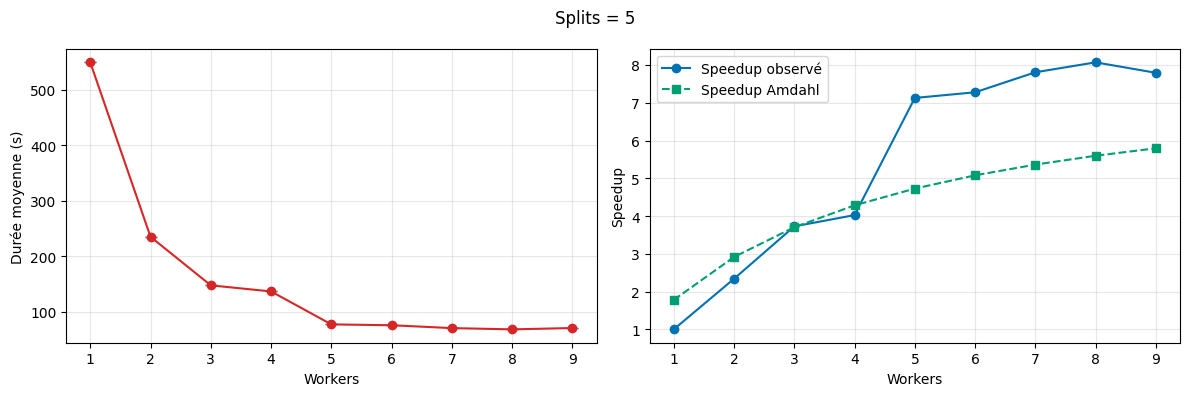

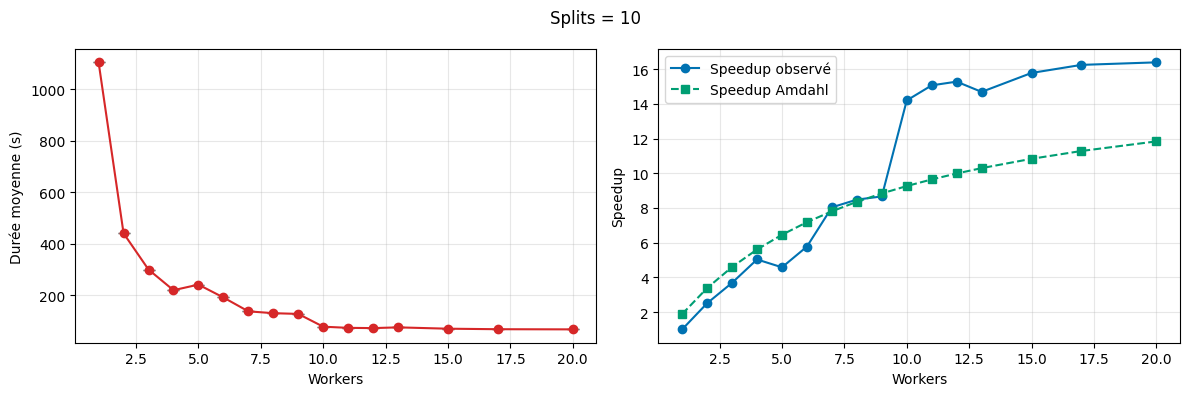

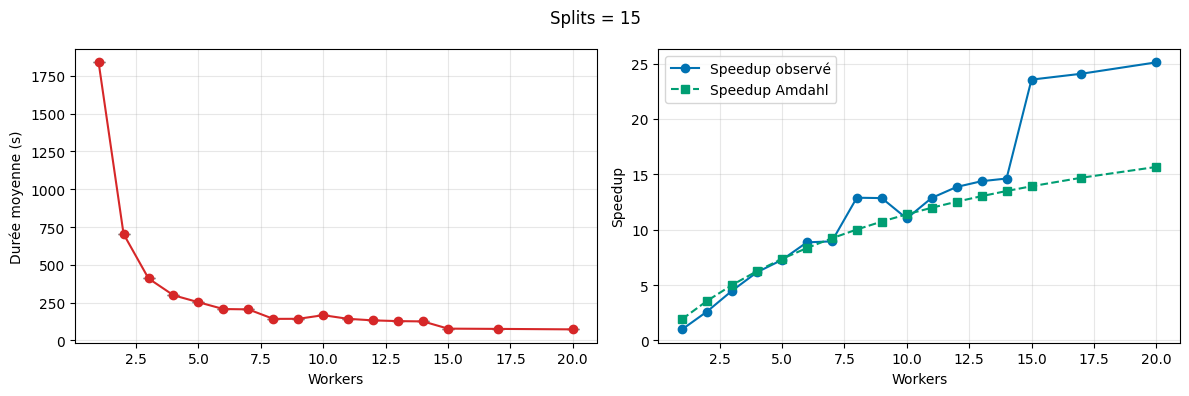

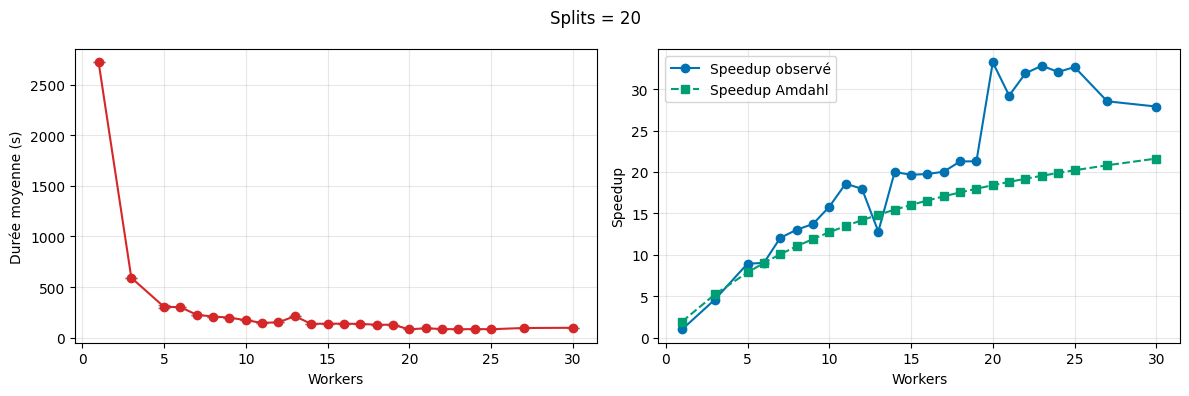

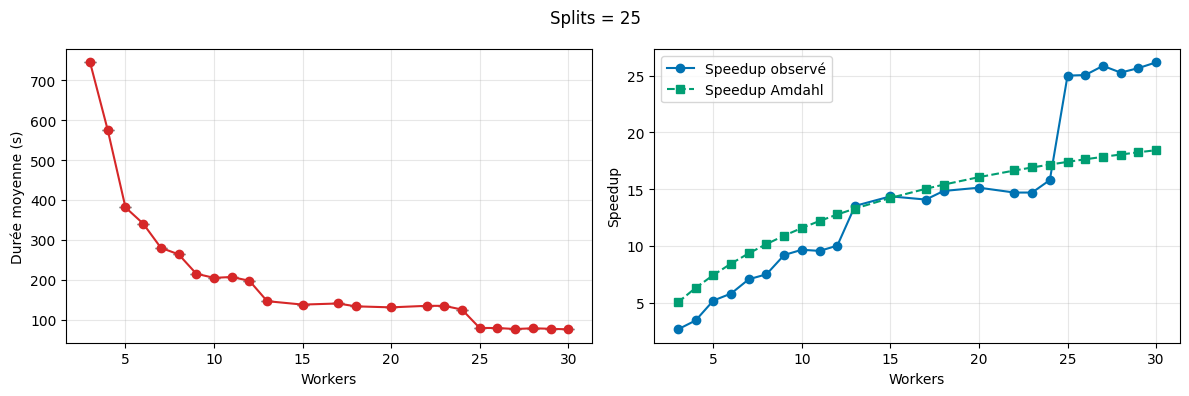

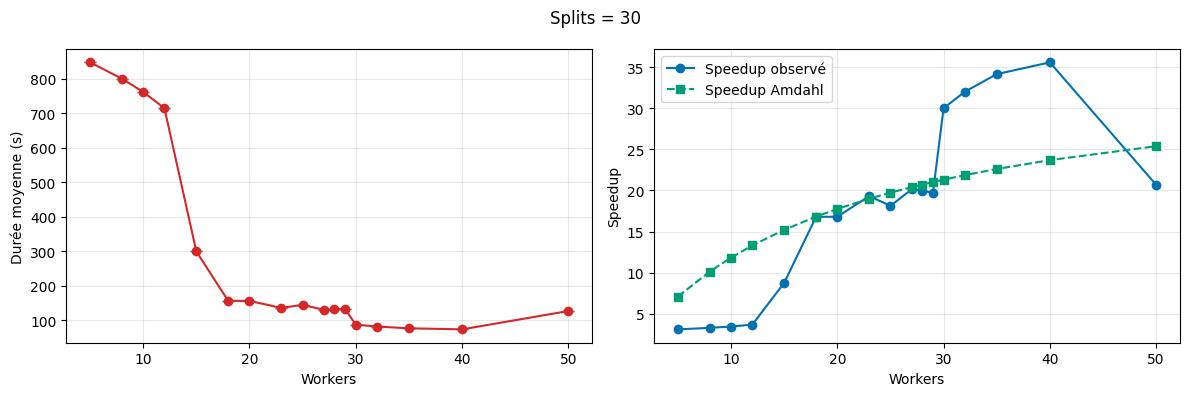

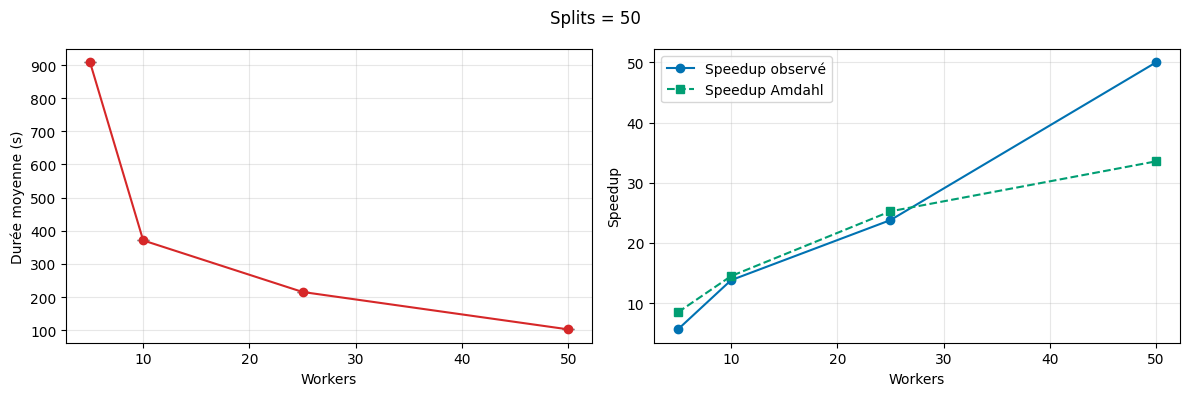

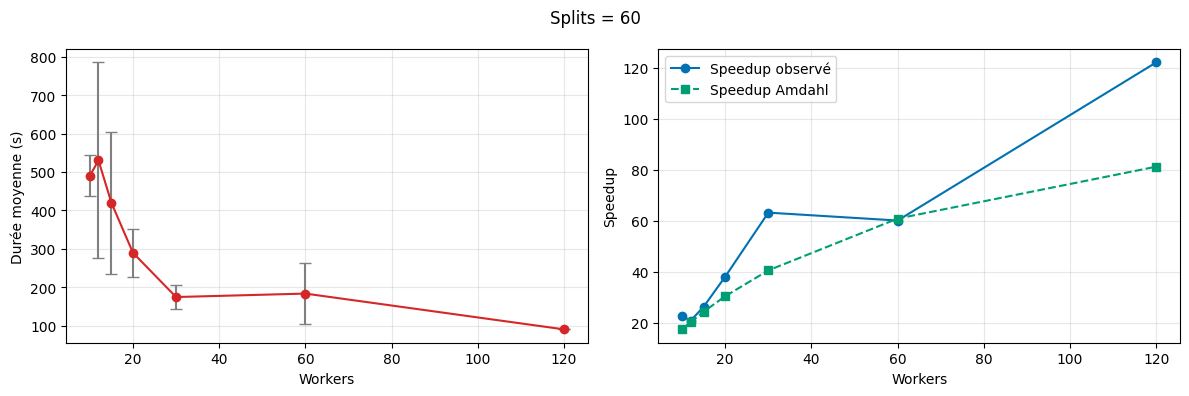

In [16]:
for splits_val, subset in summary.groupby('splits'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    p = subset['p_parallel_estimate'].iloc[0]
    f = 1.0 - p
    fig.suptitle(f"Splits = {splits_val}")

    axes[0].errorbar(
        subset['workers'],
        subset['elapsed_seconds'],
        yerr=subset['elapsed_std'],
        fmt='o-',
        color='tab:red',
        ecolor='gray',
        capsize=4,
    )
    axes[0].set_xlabel('Workers')
    axes[0].set_ylabel('Durée moyenne (s)')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(subset['workers'], subset['speedup_observe'], 'o-', label='Speedup observé')
    axes[1].plot(subset['workers'], subset['speedup_pred_amdahl'], 's--', label='Speedup Amdahl')
    axes[1].set_xlabel('Workers')
    axes[1].set_ylabel('Speedup')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## Hyperplan 3D


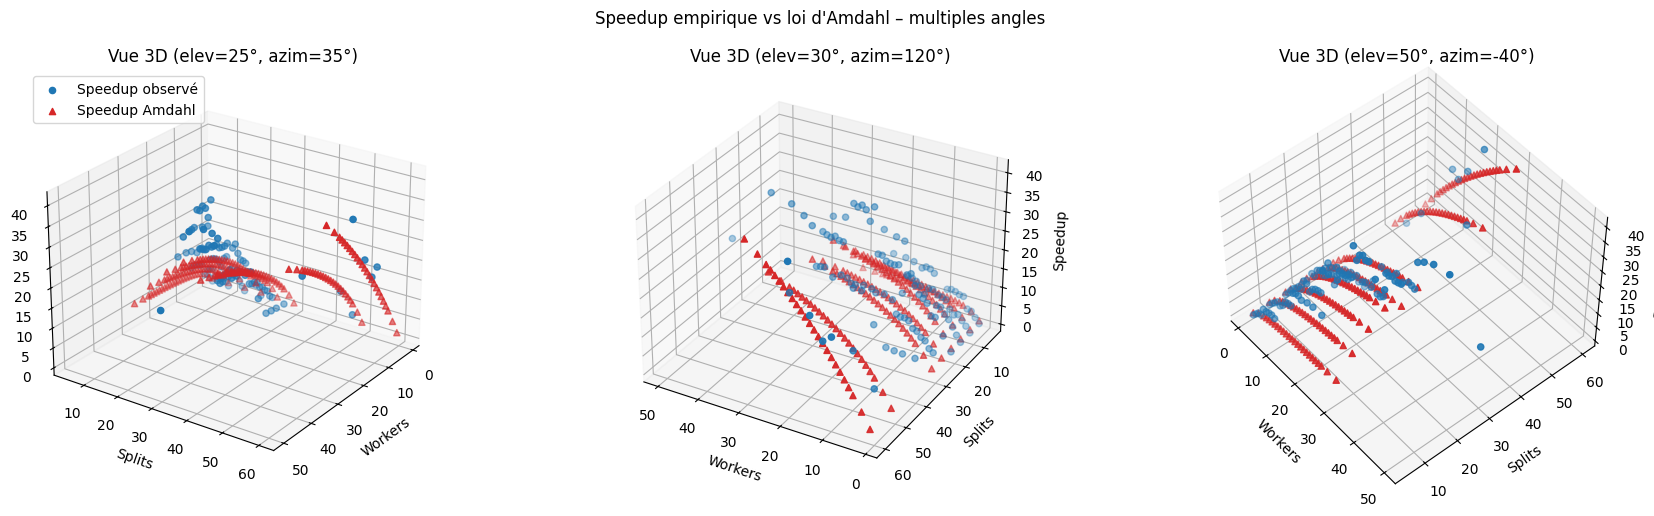

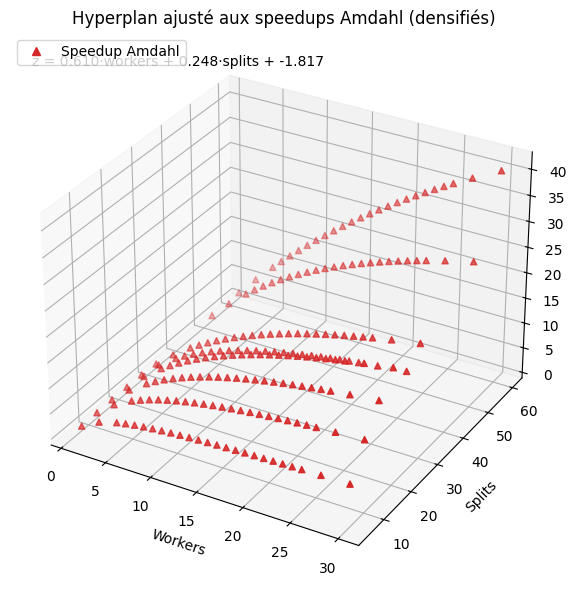

In [17]:

fig = plt.figure(figsize=(18, 5))
views = [(25, 35), (30, 120), (50, -40)]
limit_pred = None
amdahl_points = amdahl_dense if 'amdahl_dense' in globals() and not amdahl_dense.empty else summary
if amdahl_points is not None and len(amdahl_points) > 0:
    limit_pred = amdahl_points['speedup_pred_amdahl'].max()

observed_for_plot = summary
if limit_pred is not None and math.isfinite(limit_pred):
    observed_for_plot = summary[summary['speedup_observe'] <= limit_pred]

for idx, (elev, azim) in enumerate(views, start=1):
    ax = fig.add_subplot(1, len(views), idx, projection='3d')
    ax.scatter(
        observed_for_plot['workers'],
        observed_for_plot['splits'],
        observed_for_plot['speedup_observe'],
        c='tab:blue',
        label='Speedup observé'
    )
    if amdahl_points is not None and len(amdahl_points) > 0:
        ax.scatter(
            amdahl_points['workers'],
            amdahl_points['splits'],
            amdahl_points['speedup_pred_amdahl'],
            marker='^',
            color='tab:red',
            label='Speedup Amdahl'
        )
    ax.set_xlabel('Workers')
    ax.set_ylabel('Splits')
    ax.set_zlabel('Speedup')
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f'Vue 3D (elev={elev}°, azim={azim}°)')
    if idx == 1:
        ax.legend(loc='upper left')
plt.suptitle("Speedup empirique vs loi d'Amdahl – multiples angles")
plt.tight_layout()
plt.show()

amdahl_points = amdahl_dense if 'amdahl_dense' in globals() and not amdahl_dense.empty else summary
if len(amdahl_points) >= 3:
    from matplotlib.lines import Line2D

    workers = amdahl_points['workers'].to_numpy(dtype=float)
    splits_vals = amdahl_points['splits'].to_numpy(dtype=float)
    target = amdahl_points['speedup_pred_amdahl'].to_numpy(dtype=float)

    design = np.column_stack([workers, splits_vals, np.ones_like(workers)])
    coeffs, *_ = np.linalg.lstsq(design, target, rcond=None)
    a, b, c0 = coeffs

    worker_range = np.linspace(workers.min(), workers.max(), 40)
    split_range = np.linspace(splits_vals.min(), splits_vals.max(), 40)
    W, S = np.meshgrid(worker_range, split_range)
    plane = a * W + b * S + c0

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    amdahl_pts = ax.scatter(
        amdahl_points['workers'],
        amdahl_points['splits'],
        amdahl_points['speedup_pred_amdahl'],
        color='tab:red',
        marker='^'
    )
    ax.set_xlabel('Workers')
    ax.set_ylabel('Splits')
    ax.set_zlabel('Speedup')
    ax.set_title('Hyperplan ajusté aux speedups Amdahl (densifiés)')
    ax.text2D(
        0.04,
        0.94,
        f'z = {a:.3f}·workers + {b:.3f}·splits + {c0:.3f}',
        transform=ax.transAxes
    )
    legend_handles = [
        Line2D([0], [0], marker='^', color='tab:red', linestyle='', label='Speedup Amdahl')
    ]
    ax.legend(handles=legend_handles, loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Pas assez de points pour ajuster un hyperplan.")


## Langues par splits


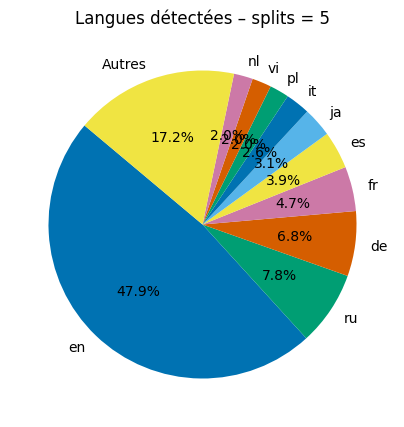

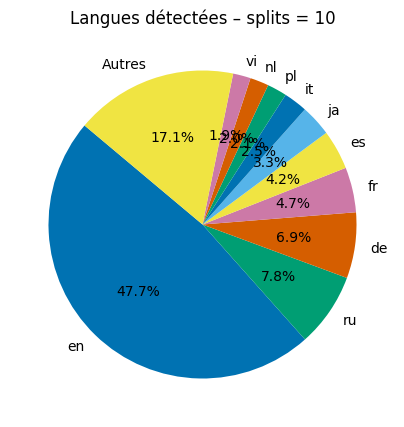

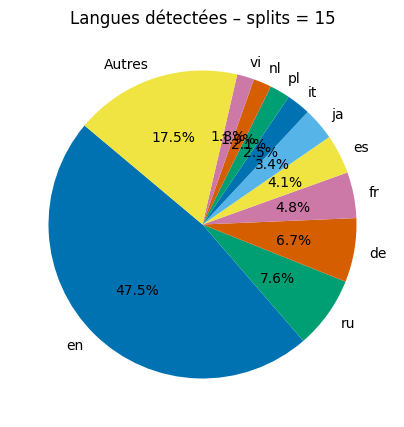

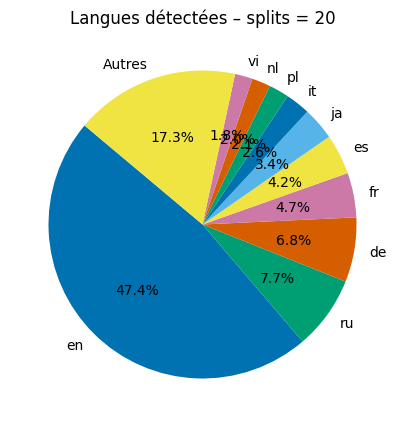

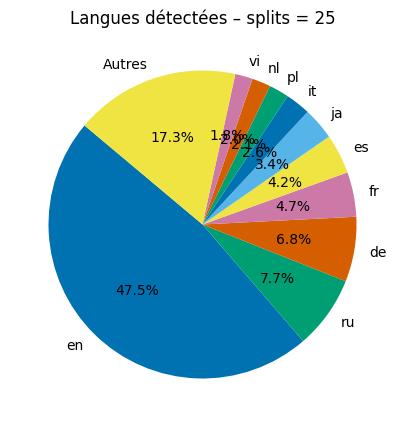

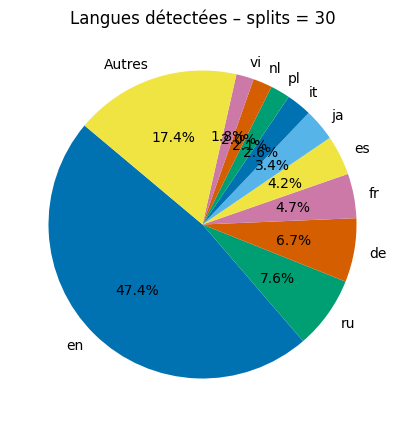

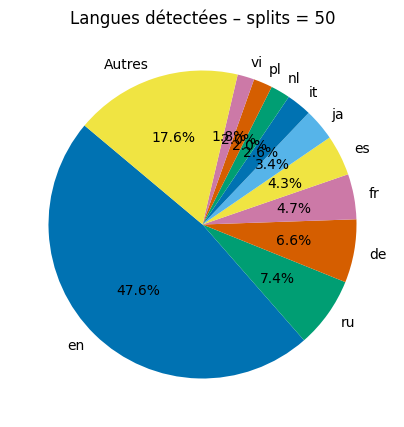

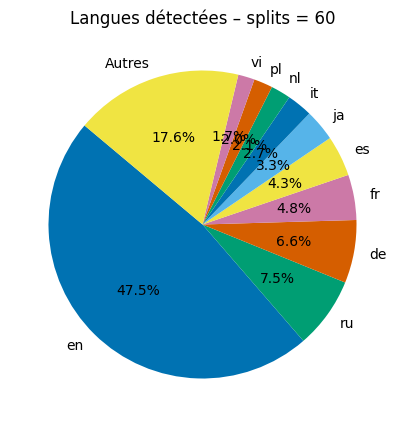

In [20]:
lang_df = df[['splits', 'language_pairs']].explode('language_pairs').dropna(subset=['language_pairs'])
if not lang_df.empty:
    lang_df[['lang','lang_count']] = pd.DataFrame(lang_df['language_pairs'].tolist(), index=lang_df.index)
    lang_df['lang_count'] = pd.to_numeric(lang_df['lang_count'], errors='coerce').fillna(0).astype(int)
    for splits_val, chunk in lang_df.groupby('splits'):
        totals = chunk.groupby('lang')['lang_count'].sum().sort_values(ascending=False)
        top = totals.head(10)
        others = totals.iloc[10:].sum()
        labels = list(top.index)
        values = list(top.values)
        if others > 0:
            labels.append('Autres')
            values.append(others)
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Langues détectées – splits = {splits_val}')
        plt.show()
else:
    print('Aucune information sur les langues.')
